In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from IPython.display import Markdown

import planet_ruler.observation as pro
from planet_ruler.demo import make_dropdown, load_demo_parameters, explain_init_values
from planet_ruler.plot import plot_3d_solution

# Choose a Target

Run the next cell and choose a target from the dropdown menu.

In [3]:
demo = make_dropdown()
display(demo)

Dropdown(description='Demo:', options=(('Pluto', 1), ('Saturn-1', 2), ('Saturn-2', 3), ('Earth', 4)), value=1)

In [4]:
demo_params = load_demo_parameters(demo)

# Load an Image

In [5]:
Obs = pro.LimbObservation(
    image_filepath=demo_params['image_filepath'],
    fit_config=demo_params['fit_config'])

In [6]:
# Obs.restrict_image(ymax=400)
# Obs.restrict_image(xmin=1500, xmax=2500, ymax=800)

### Fix me

Let's start out with this image from NASA's New Horizons mission. A couple things to note:

- You can clearly see the 'limb' of Pluto here -- the edge where the dwarf planet meets space.
- We are obviously quite high up (around 1,200 km), which makes the curvature really apparent.

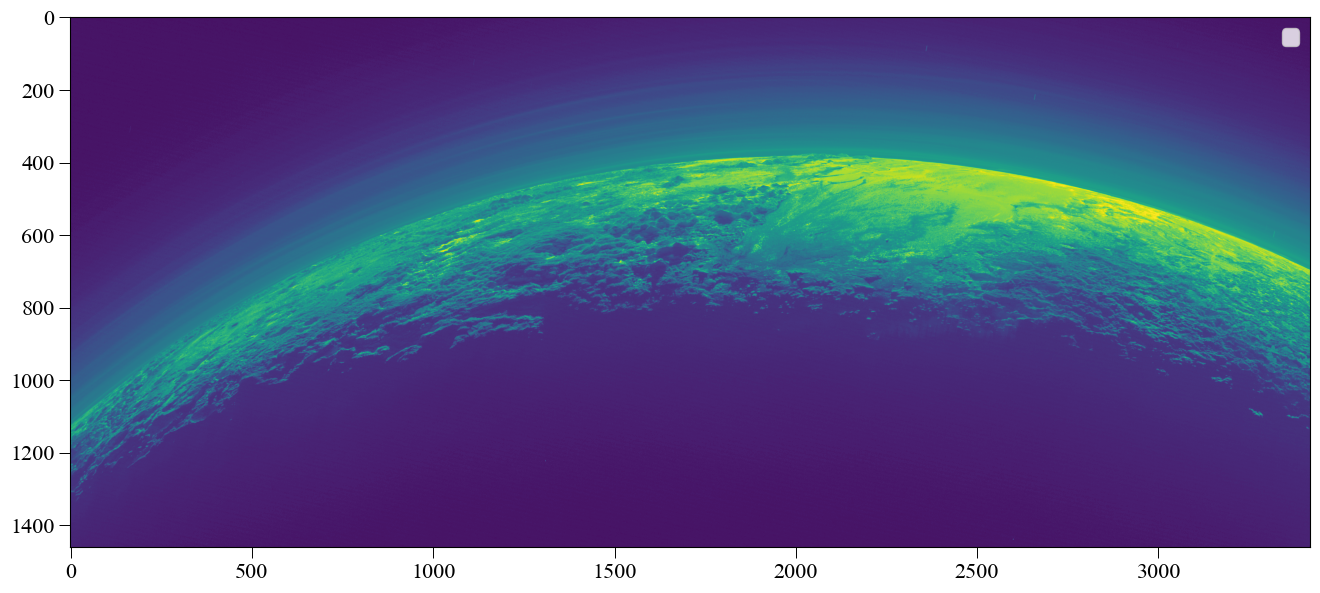

In [7]:
Obs.plot()

# Detect Limb

Next we want to define where the limb is so we can start figuring out the radius. There are many ways to go about this. For example, we could look for regions of high contrast, train some object detection ML, or simply draw by hand. Being a physics nerd I will do something a little different and fun -- we will simulate dropping a string down from the top of the image and let it 'settle' on the limb.

To make that happen we first turn the image into a topographical map by treating pixel brightness as elevation. That might look something like so:

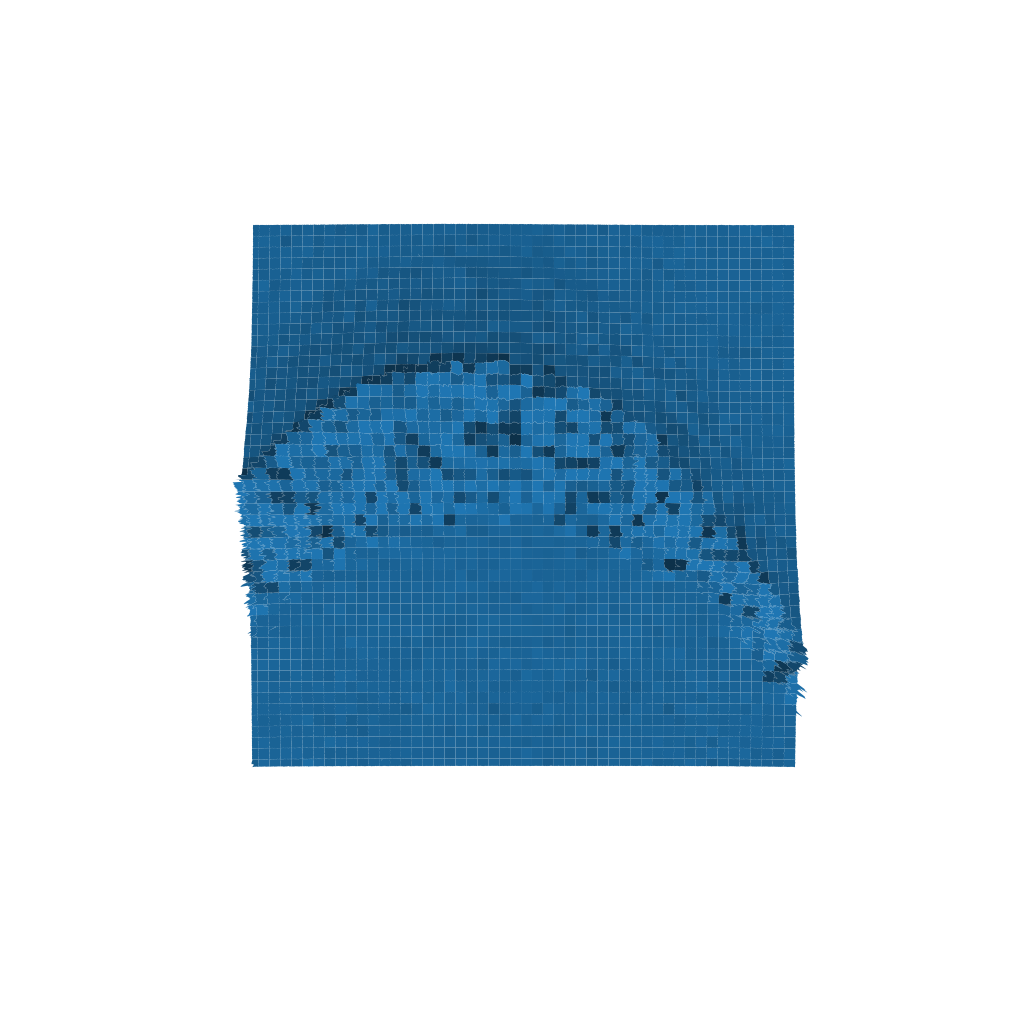

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10, 10))

# summing each pixel across colors to get intensity
z = Obs.image #.sum(axis=-1)
z = np.clip(z, None, 1000)
nrows, ncols = z.shape
x = np.arange(ncols)
y = np.arange(nrows) 

x, y = np.meshgrid(x, y)

ls = LightSource(altdeg=30, azdeg=-15)
ax.plot_surface(x, y, z, lightsource=ls)
ax.view_init(elev=90, azim=0, roll=-90)

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

plt.axis('off')
plt.show()

If we tilt this landscape back somewhat and drop a string (subject to gravity and tension) onto it, it will settle where the hill starts to rise -- exactly the limb we are trying to detect.

Running the next line will perform the simulation. It takes a couple minutes but the results are pretty robust, as most physical systems are.

In [9]:
Obs.detect_limb(**demo_params['limb_config'])

computing gradient force map...
dropping horizon string...


  0%|          | 0/200000 [00:00<?, ?it/s]

Let's take a look at the position of the string over time. It becomes less transparent as time evolves and it settles onto the limb.

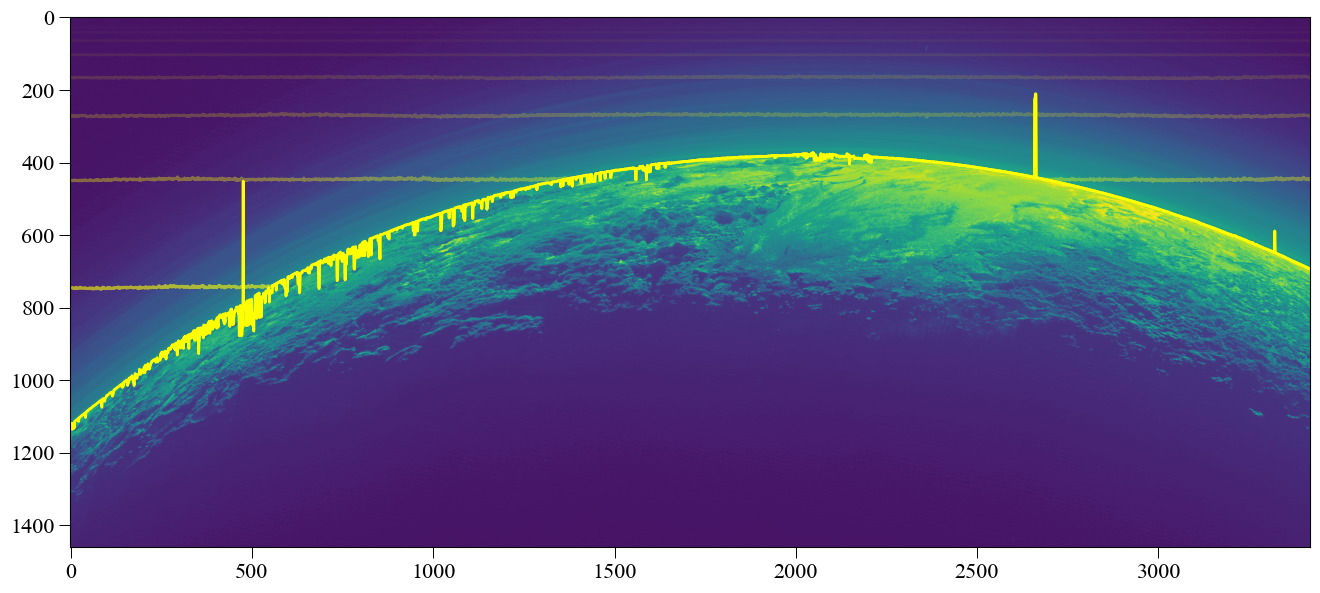

In [10]:
string_positions = Obs._string_drop.string_positions
n_pos = len(string_positions)

plt.imshow(Obs.image)
steps = np.logspace(1, np.log10(n_pos - 1), num=20).astype(int)
for step in steps:
    pos = string_positions[step]
    plt.plot(np.arange(len(pos)), pos, c='yellow', alpha=(step)/(n_pos))
plt.show()

We can now smooth things out and take a look at the fitted limb location.

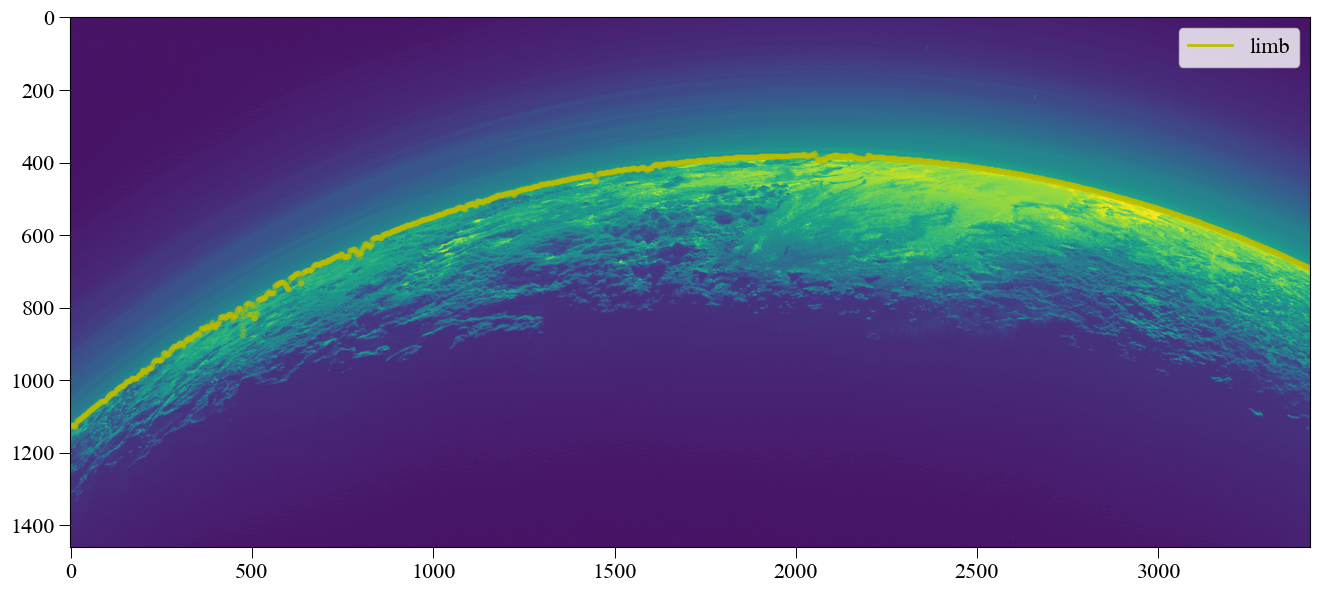

In [11]:
Obs.smooth_limb(method='rolling-median', window_length=10)
Obs.plot()

Let's add a save point in case we don't want to do all that again.

In [12]:
# Obs.save_limb(demo_params['limb_save'])

# Fit Planet Radius

In [13]:
with open(demo_params['parameter_walkthrough'], 'r') as f:
    display(Markdown(f.read()))

Now for the hard part. We need to deduce the radius of the object below us by leveraging what we know and fitting what we do not.

So -- what do we know?

Let's start with a list of the free parameters in the fit. These are:
- **[r]** Radius of the planet (m)
- **[h]** Height of the camera above the surface (m)
- **[f]** Focal length of the camera (m)
- **[fov]** The angle observed by the camera (degrees)
- **[x0]** The x-axis principle point (center of the image in pixel space)
- **[y0]** Same as x0 but for the y-axis
- **[theta_x]** Rotation around the x (horizontal) axis, AKA pitch. (radians)
- **[theta_y]** Rotation around the y (vertical) axis, AKA yaw. (radians)
- **[theta_z]** Rotation around the z (toward the limb) axis, AKA roll. (radians)
- **[origin_x]** Horizontal offset from the object in question to the camera (m)
- **[origin_y]** Distance from the object in question to the camera (m)
- **[origin_z]** Height difference from the object in question to the camera (m)

To help the fit we can give initial guesses and boundaries to each of these features. This is a tough optimization with a lot of parameter space, degeneracies, and weird inflection points, so the more help we can give the more likely we are to get somewhere meaningful. Let's step through the parameters.

- **[r]** Radius of the planet (m)
  
> Obviously we are trying to find out **r** so we might not have much to go on here, but that doesn't mean we can't put in some reasonable bounds. We know for example that we are looking at a rocky dwarf planet that is quite spherical which is a clue to the minimum radius. I leave it to the user to do that napkin math -- today let's just put in a guess for the radius at 750 km -- in the ballpark of the truth (1188 km) but not so close to give away the answer. We set the bounds loosely to 600-1900 km.

- **[h]** Height of the camera above the surface (m)

> Here we can make a guess using the known parameters of NASA's New Horizons mission. The NASA image data claims a distance of 18,000 km so we'll start there, plus or minus a few thousand km as boundaries.

- **[f]** Focal length of the camera (m)

> From the stated mission parameters, the [RALPH](https://www.dpreview.com/articles/5293237047/nasa-new-horizons-probe-cameras-ralph) camera has a 0.6575 m focal length. Since we're pretty sure about this one, let's give it a very small (0.5cm) tolerance.

- **[fov]** The angle observed by the camera (degrees).

> Again we can pull this from the mission parameters -- 5.7 degrees. The solver will automatically give this a 1% tolerance.

- **[x0]** The x-axis principle point (center of the image in pixel space)

> This one will be set automatically and fixed, assuming the camera has a CCD centered on the optical axis.

- **[y0]** Same as x0 but for the y-axis

> Same as y0.

- **[theta_x]** Rotation around the x (horizontal) axis, AKA pitch. (radians)
- **[theta_y]** Rotation around the y (vertical) axis, AKA yaw. (radians)
- **[theta_z]** Rotation around the z (toward the limb) axis, AKA roll. (radians)

> These describe where the camera is pointing. We start it in the rough direction the limb should be given our assumptions so far about the height and radius, but don't give any real constraints -- i.e., they are loose enough that it can point wherever it wants.

- **[origin_x]** Horizontal offset from the object in question to the camera (m)
- **[origin_y]** Distance from the object in question to the camera (m)
- **[origin_z]** Height difference from the object in question to the camera (m)

> These tell us where the camera is in space relative to the coordinate origin. But since we decide where the origin is, we can just set it to equal the camera position. Now these are all zero by definition -- they can be manipulated for demonstration but don't change these if you want to get the correct answer.

You can see the current initial parameter set [here](https://github.com/bogsdarking/planet_ruler/blob/c8c0a39cae7712363491bc60c861d1a2e410b745/config/pluto-new-horizons.yaml).

Let's try that fit!

In [ ]:
# Set n_jobs to the number of processors you feel comfortable utilizing.
Obs.fit_limb(max_iter=15000, n_jobs=6, seed=0)

## Check Fit

### By Eye

Not bad, right? It's not challenging to end up with a fit that doesn't converge well and appears to have nothing to do with the limb in question. If that happens, don't despair! If the limb detection went okay, it usually it means some tweaking of the parameter ranges or optimizer properties is in order.

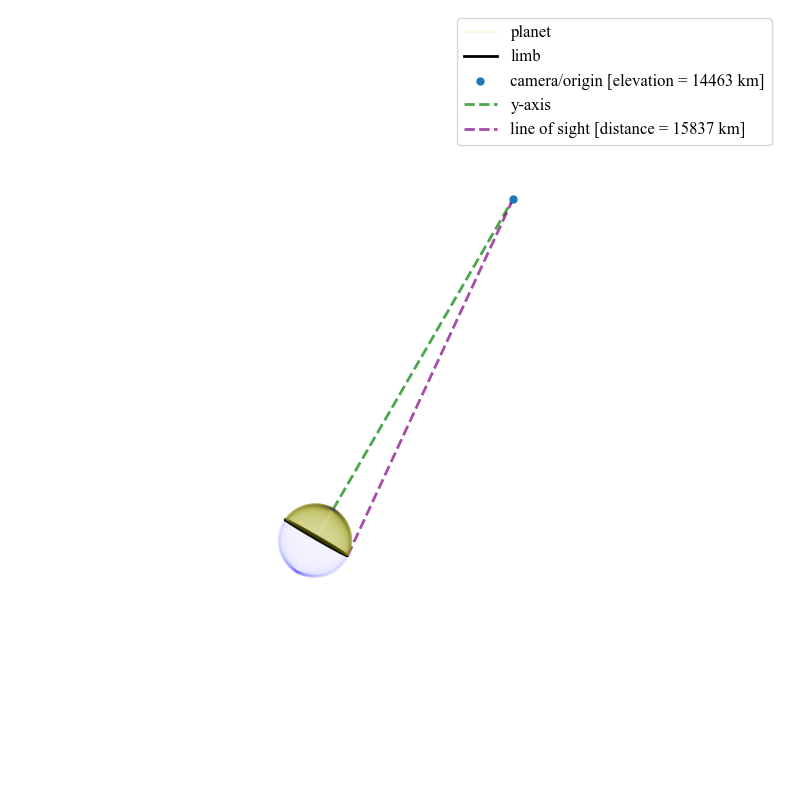

In [18]:
plot_3d_solution(**Obs.best_parameters)

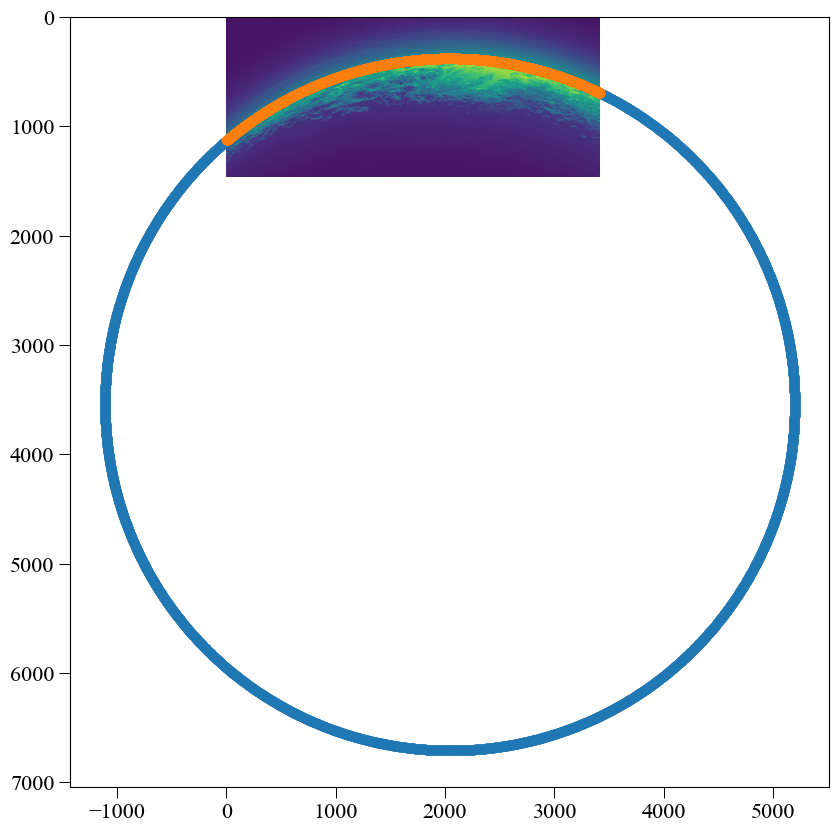

In [15]:
pro.plot_full_limb(Obs)

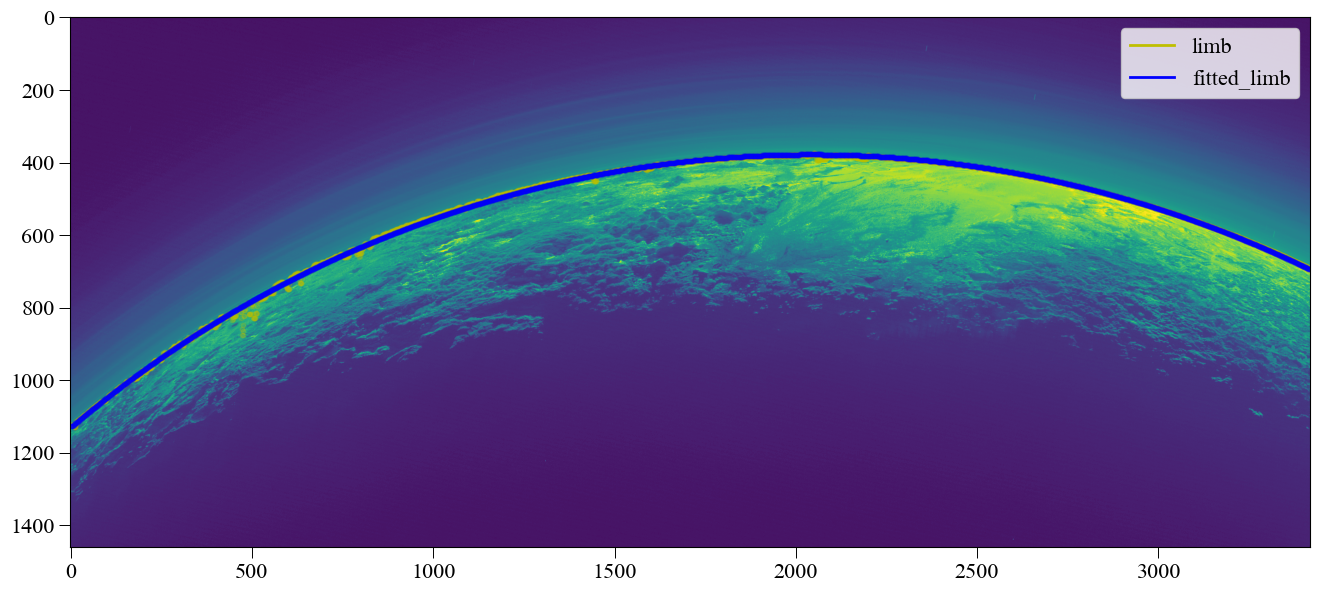

In [16]:
Obs.plot()

### Posteriors

To understand this section you need to know a bit about what minimizer we used to solve the problem. This is using something called [differential evolution](https://en.wikipedia.org/wiki/Differential_evolution). It's a (terribly named) way of minimizing a loss function that is non-differentiable. Basically it simulates the 'evolution' of a population composed of parameter value sets. So [r=1, h=2, etc.] could be one unit of the population. These units are mutated and combined over many generations where only the best-fitting survive. When we end the simulation we have an optimal parameter set and a population that is hopefully still competitive. We can think of that population as something like a 'posterior', or measure of uncertainty in each parameter's observed value. Another totally valid method of optimization would have been a Bayesian MCMC and it would also give us posterior distributions that we could check out.

Below we plot all these populations/posteriors and see if they look good. What is good? Ideally they should form a concave U-shape around the best value and not be too much up against either of the limits we imposed in the fit. If the latter is taking place, we might not be reaching the true minimum and it's hard to take the results too seriously. In that case, try the fit again but move the constraints out a little to give the fit some breathing room. I say a little bit because you don't want to make the constraints too wide either -- there really is a sweet spot that doesn't explicitly block the best parameter values, but gives the minimizer enough to work with that it can arrive there in our lifetimes.

I already went through the trial and error to get the following posteriors to look right -- if implementing the code on a new image, take these an example of what to shoot for.

In [16]:
pro.unpack_diff_evol_posteriors(Obs).describe()

r             h           f  num_sample         fov  \
count  1.280000e+02  1.280000e+02  128.000000       128.0  128.000000   
mean   1.394468e+06  1.400697e+07    0.656163      5000.0    5.660098   
std    5.410690e+04  5.452663e+05    0.003782         0.0    0.008514   
min    1.220195e+06  1.218236e+07    0.650311      5000.0    5.644429   
25%    1.362483e+06  1.368622e+07    0.653008      5000.0    5.656067   
50%    1.383205e+06  1.391007e+07    0.656175      5000.0    5.659253   
75%    1.436994e+06  1.442343e+07    0.658839      5000.0    5.662763   
max    1.561655e+06  1.565387e+07    0.664337      5000.0    5.692415   

          theta_x     theta_y     theta_z         mse  
count  128.000000  128.000000  128.000000  128.000000  
mean     1.424524   -1.426661    3.075122   38.010700  
std      0.002217    0.004969    0.002196    0.162476  
min      1.420285   -1.435782    3.071041   37.868340  
25%      1.422886   -1.430366    3.073479   37.929301  
50%      1.424567   -1.426448    3.075271   37.961374  
75%      1.425718   -1.424130    3.076290   38.023267  
max      1.434858   -1.400757    3.085313   39.105942

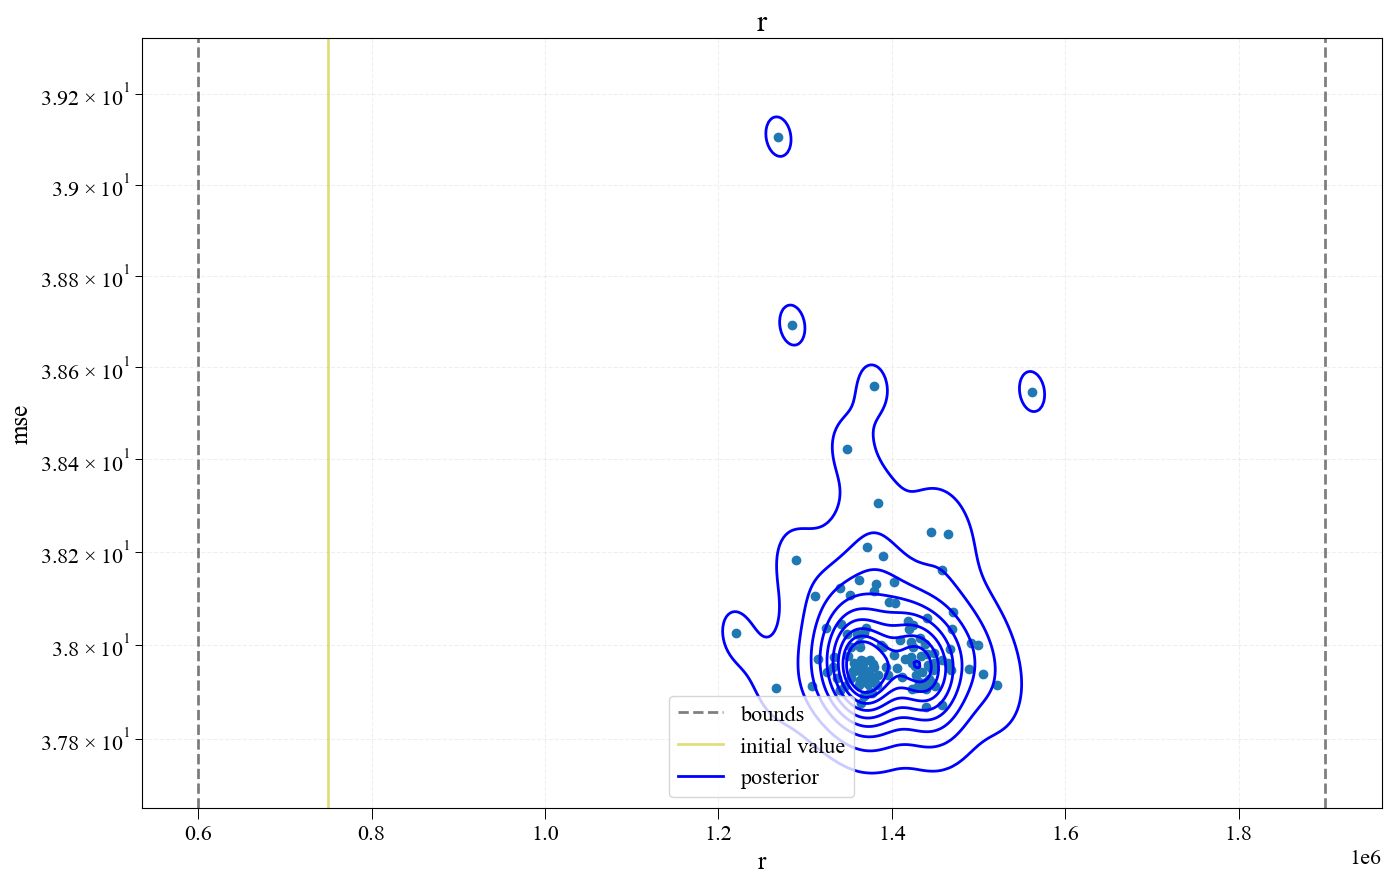

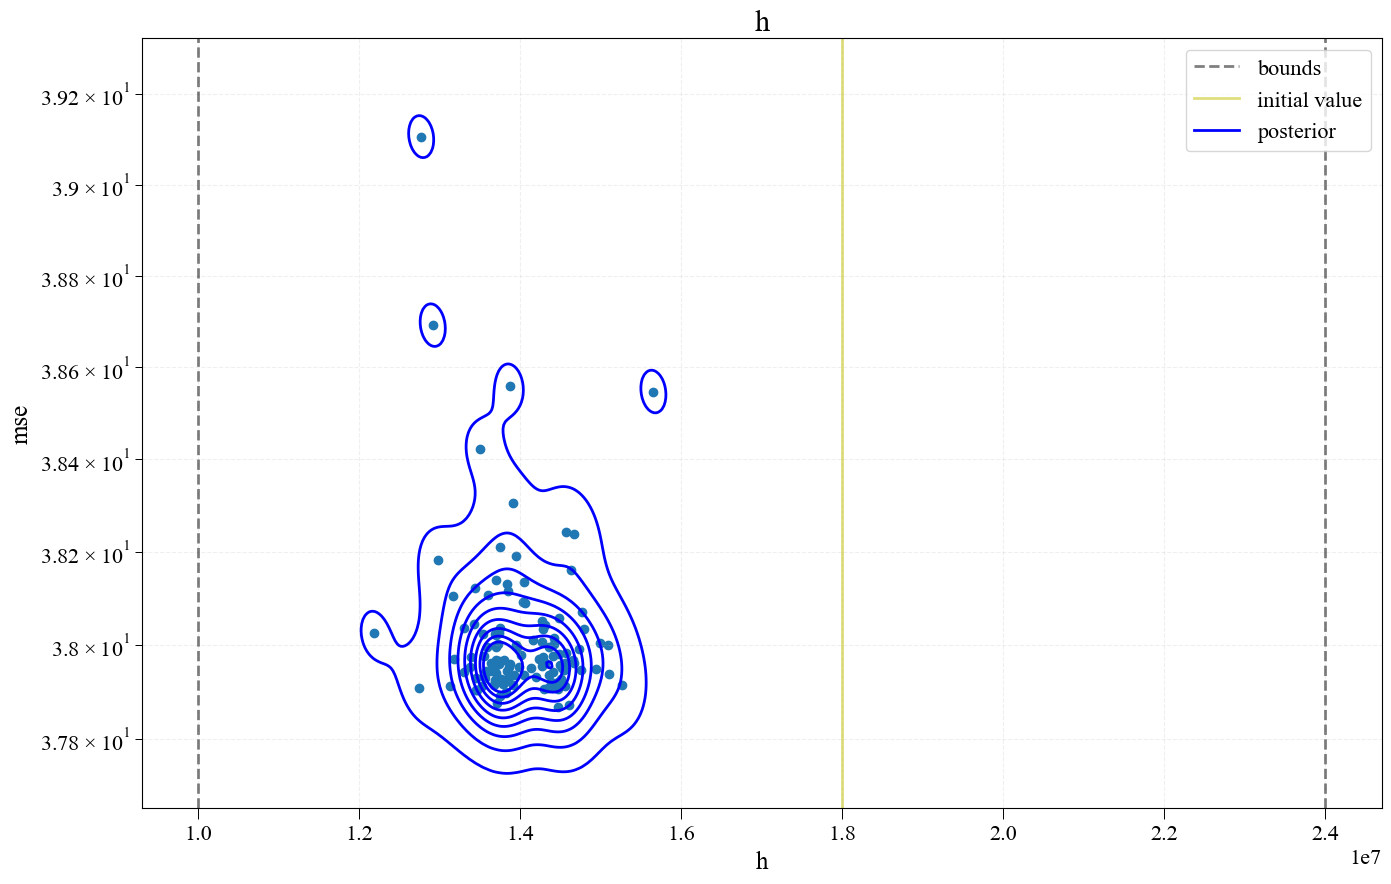

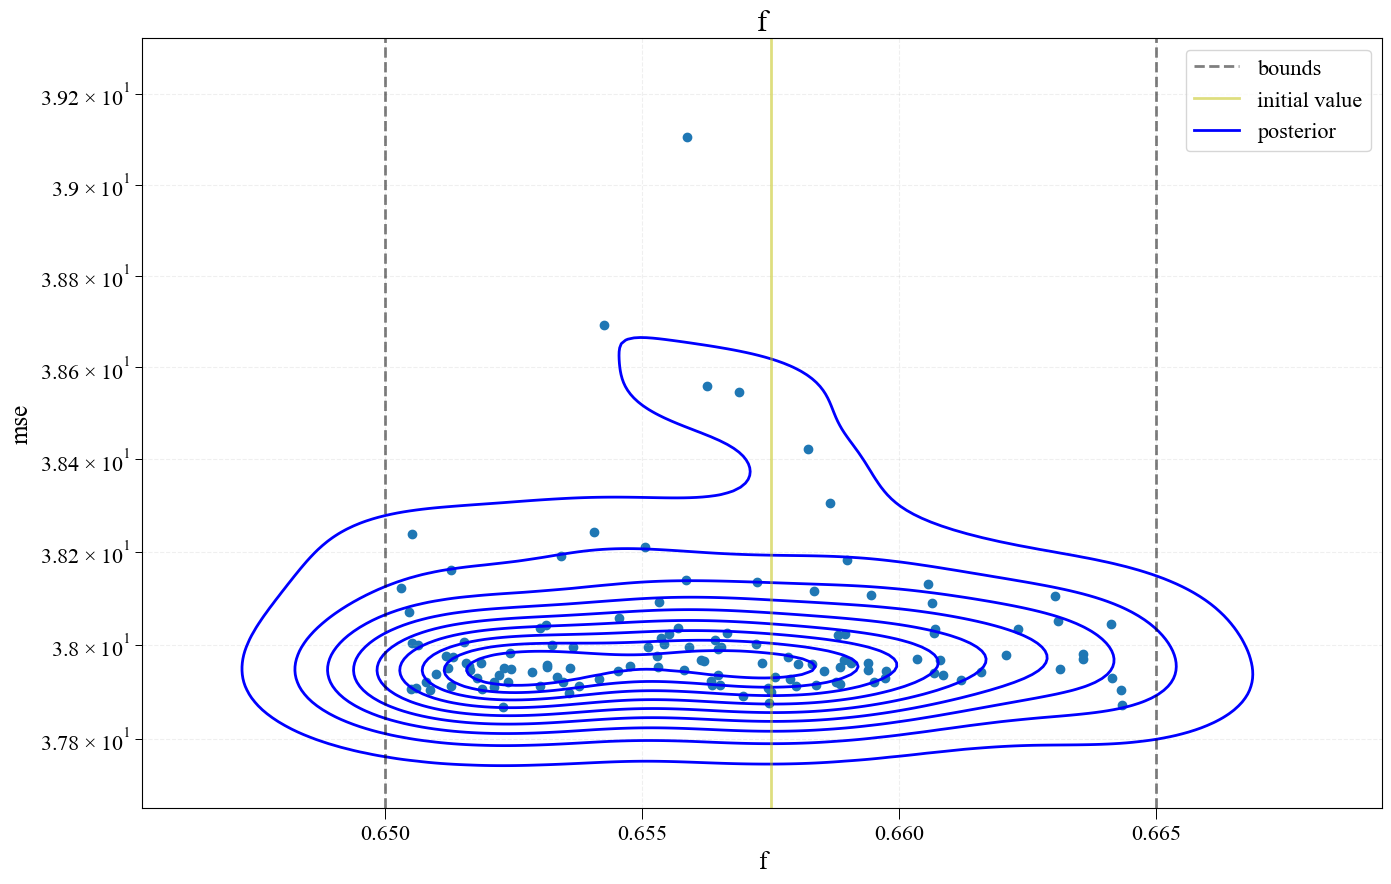

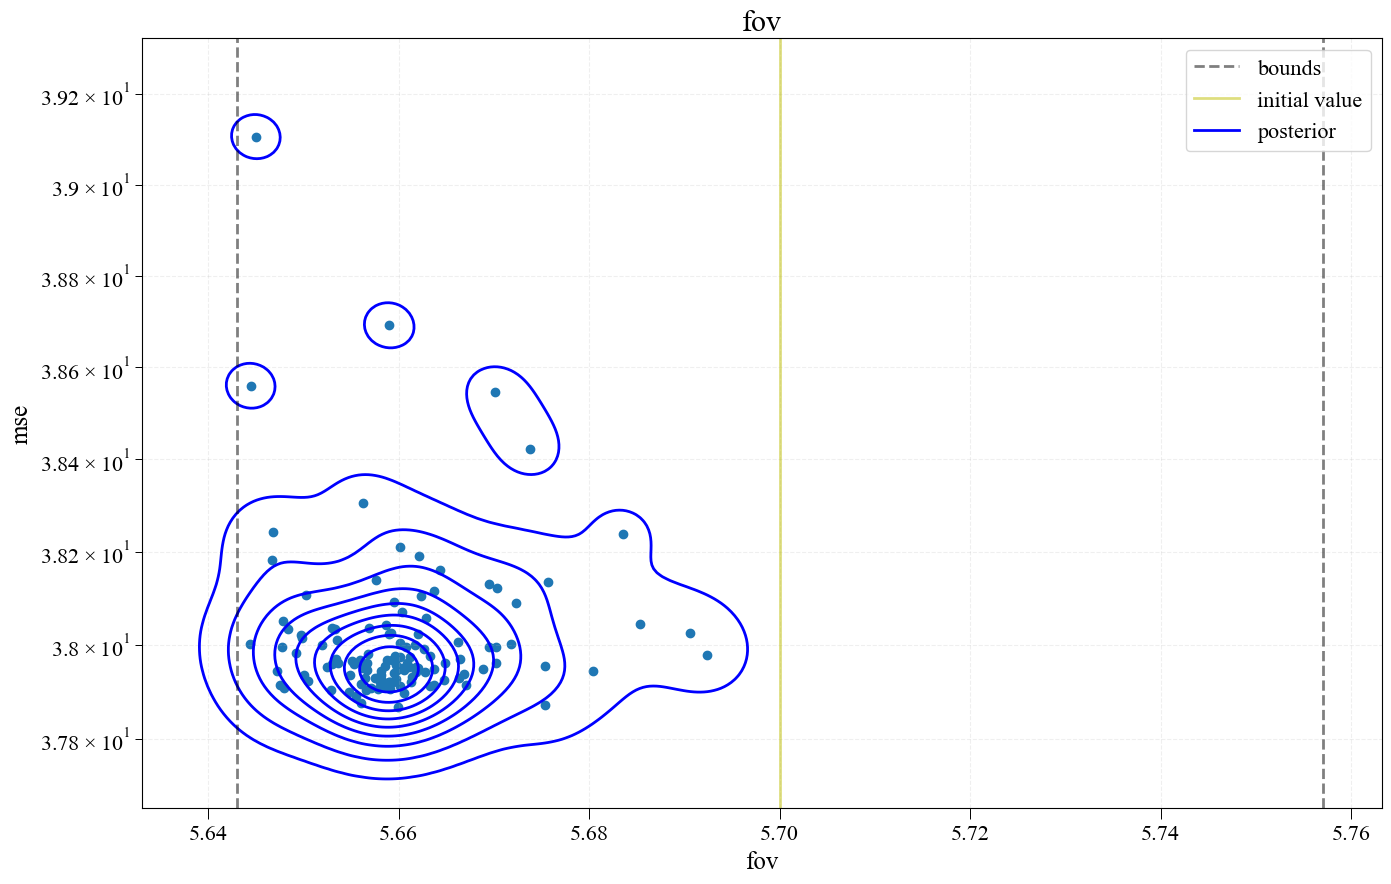

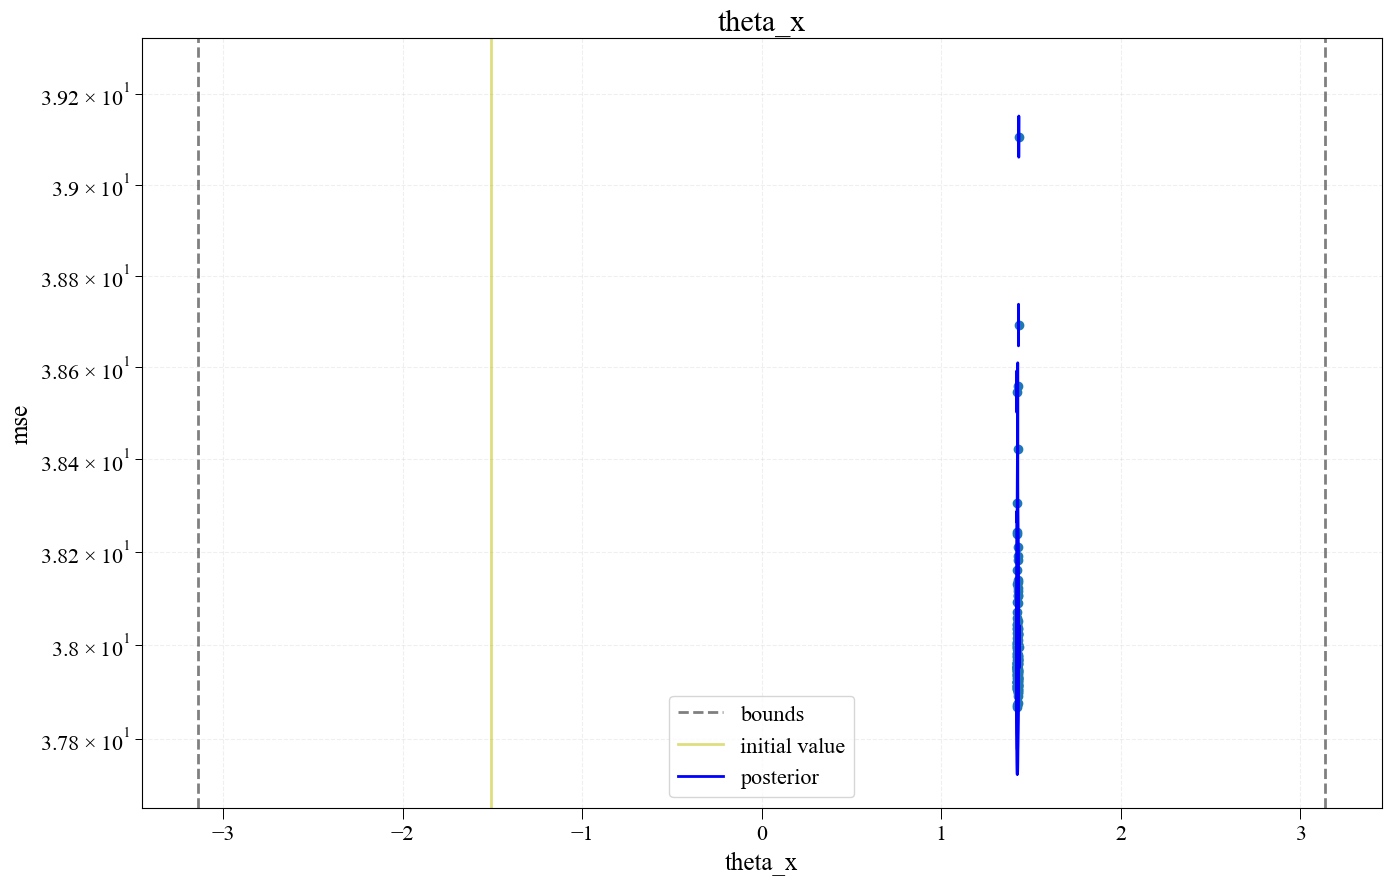

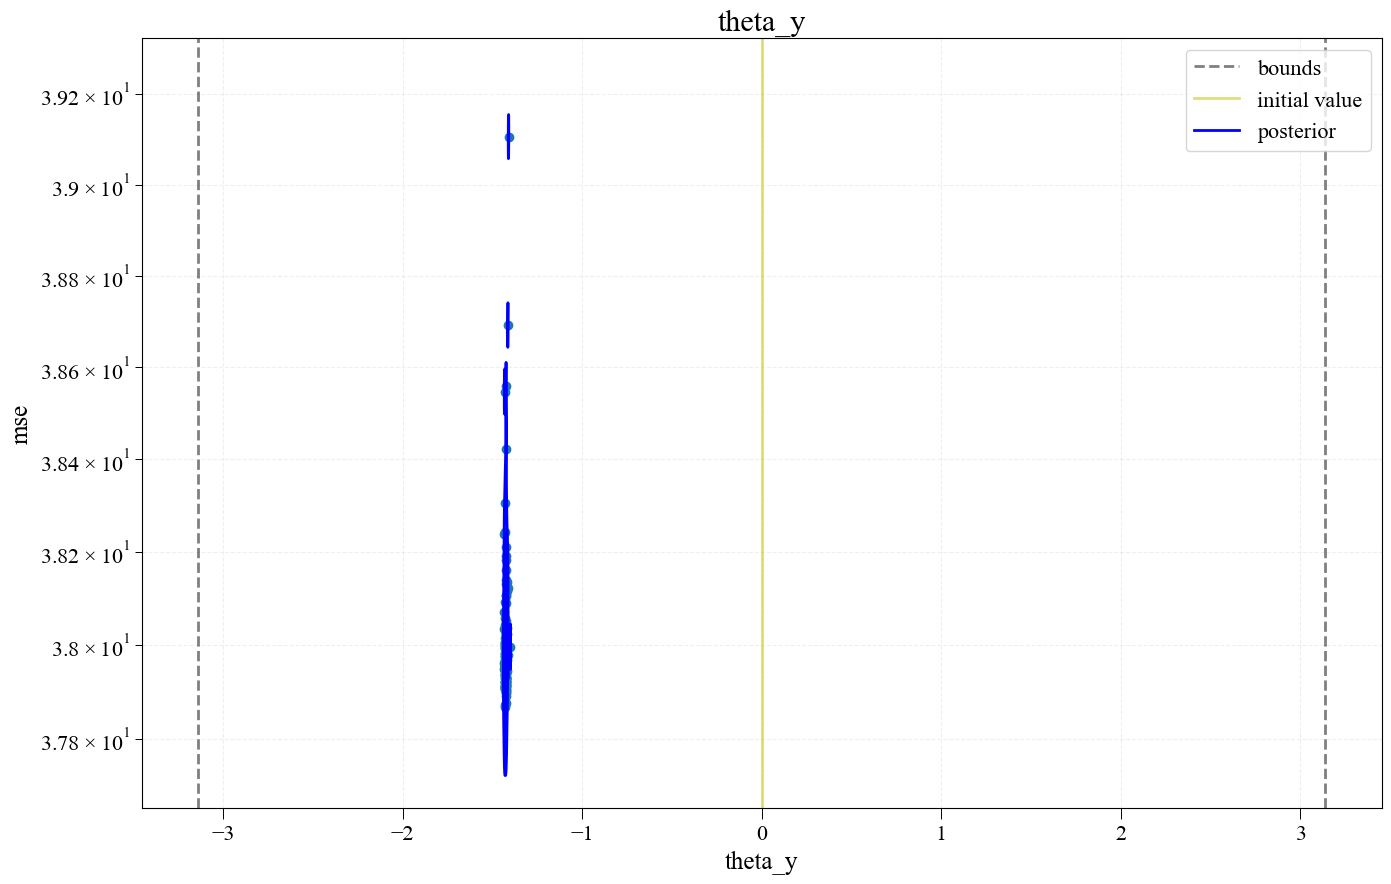

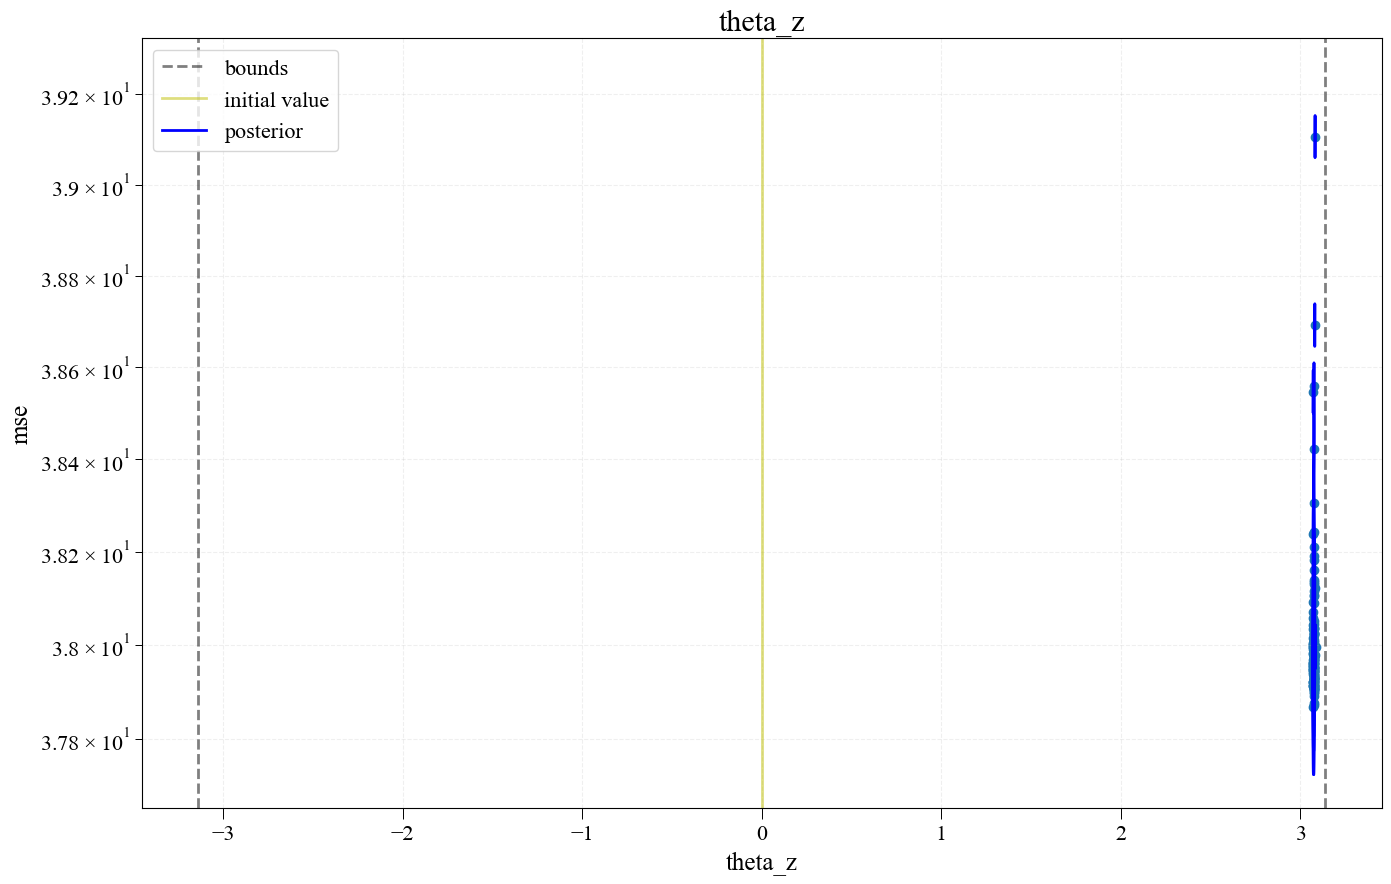

In [18]:
pro.plot_diff_evol_posteriors(Obs, show_points=True)

# The Answer!

At long last. After convincing ourselves that we can trust our results, let's take a look.

In [19]:
final_params = Obs.init_parameter_values.copy()
final_params.update(Obs.best_parameters)
fitted_radius = final_params['r'] / 1000
fit_population = pro.unpack_diff_evol_posteriors(Obs)
rough_uncertainty = fit_population['r'].std() / 1000
rough_uncertainty = np.ptp(fit_population['r']) / 1000
pct_error = (fitted_radius - demo_params['true_radius']) / demo_params['true_radius'] * 100

print(f"Our estimate of {demo_params['target']}'s radius is{fitted_radius: .1f} \u00B1{rough_uncertainty: .0f} kilometers.")
print(f"That puts us{pct_error: .1f}% away from the true value of {demo_params['true_radius']} km.")

Our estimate of Pluto's radius is 1439.4 ± 341 kilometers.
That puts us 21.2% away from the true value of 1188 km.


The value is quite close to the truth. I wouldn't plan a space trip around it but it isn't bad for a single image and rough idea of what camera was used!

See below where all the other parameters ended up relative to their initial values.

In [20]:
pro.package_results(Obs)

fit value  initial value
parameter                             
r          1.439372e+06   7.500000e+05
h          1.446338e+07   1.800000e+07
f          6.522870e-01   6.575000e-01
fov        5.659905e+00   5.700000e+00
theta_x    1.422880e+00  -1.508843e+00
theta_y   -1.430374e+00   0.000000e+00
theta_z    3.073464e+00   0.000000e+00

In [35]:
import pymc as pm

In [36]:
data = np.random.normal(loc=0, scale=1, size=1000)

In [37]:
def normal_sim(rng, a, b, size=1000):
    return rng.normal(a, b, size=size)

In [ ]:
with pm.Model() as example:
    a = pm.Normal("a", mu=0, sigma=5)
    b = pm.HalfNormal("b", sigma=1)
    s = pm.Simulator("s", normal_sim, params=(a, b), sum_stat="sort", epsilon=1, observed=data)

    idata = pm.sample_smc()
    idata.extend(pm.sample_posterior_predictive(idata))